<h2>Experimenting with Saba: astropy-Sherpa interface </h2>

Here we repeat some tests in experiment_redshift.ipynb, replacing the astropy fitter used there (LevMarLSQFitter) with any one of the Sherpa optimizers.

('INPUT MODEL: ', <CompoundModel0(z_0=-0.16666666666666663, amplitude_1=100.0, mean_1=6500.0, stddev_1=165.0, name=u'')>)
('FITTED MODEL: ', <CompoundModel0(z_0=-0.14836674921642418, amplitude_1=99.70399679088663, mean_1=6642.607641396579, stddev_1=169.26398350342583, name=u'')>)
('FITTED z: ', 0.17421436877894814)


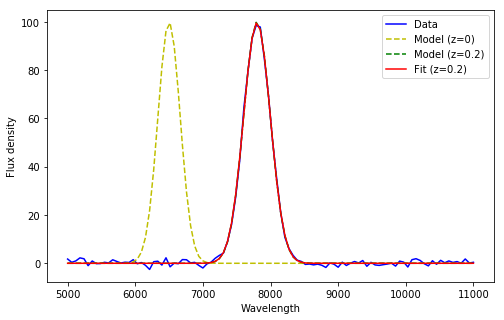

In [1]:
from astropy.modeling.fitting import SherpaFitter

import numpy as np
from astropy.modeling.models import Gaussian1D, RedshiftScaleFactor, Linear1D
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
x = np.linspace(5000, 11000, 100)
g0 = Gaussian1D(100, 6500 * 1.2, 200) 
y = g0(x)
y += np.random.normal(0., 1., x.shape)

g1 = Gaussian1D(100, 6500, 165.)
z = 0.2
rs = RedshiftScaleFactor(z).inverse
g_c = rs | g1

fitter = SherpaFitter(statistic='leastsq', optimizer='levmar', estmethod='confidence')
g_fit = fitter(g_c, x, y)

print("INPUT MODEL: ", g_c)
print("FITTED MODEL: ", g_fit)
fitted_z = RedshiftScaleFactor(g_fit.parameters[0]).inverse.z.value
print("FITTED z: ", fitted_z)

plt.figure(figsize=(8, 5))  
plt.plot(x, y, 'blue', label='Data')
plt.plot(x, g1(x), 'y--', label='Model (z=0)')
plt.plot(x, g_c(x), 'g--', label='Model (z=%3.1f)'%z)
plt.plot(x, g_fit(x), 'r', label='Fit (z=%3.1f)'%fitted_z)
plt.xlabel('Wavelength')
plt.ylabel('Flux density')
plt.legend()


In [2]:
np.random.seed(0)
x = np.linspace(5000, 11000, 100)
g0 = Gaussian1D(100, 6500 * 1.2, 200) 
y = g0(x)
y += np.random.normal(0., 1., x.shape)

for z in (0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4):
    for sigma in (100., 120., 140., 160., 180., 200., 220., 240., 260.):
        g1 = Gaussian1D(100., 6500., sigma)
        rs = RedshiftScaleFactor(z).inverse
        g_c = rs | g1

        g_c.fixed['mean_1'] = True
        fitter = SherpaFitter(statistic='leastsq', optimizer='levmar', estmethod='confidence')
        g_fit = fitter(g_c, x, y)
        fitted_z =  RedshiftScaleFactor(g_fit.parameters[0]).inverse.z.value
        fitted_sigma = g_fit.stddev_1.value
        
        hit = '*' if (fitted_z>0.19 and fitted_z<0.21) and (fitted_sigma>160. and fitted_sigma<170.) else ' '
        print("%4.2f   %5.1f    %4.2f  %4.1f   %s" % (z, sigma, fitted_z, fitted_sigma, hit))

0.00   100.0    0.20  -165.6    
0.00   120.0    0.03  -26.3    
0.00   140.0    0.20  165.6   *
0.00   160.0    0.20  165.6   *
0.00   180.0    0.03  30.1    
0.00   200.0    0.03  27.8    
0.00   220.0    0.03  29.0    
0.00   240.0    0.20  165.6   *
0.00   260.0    -0.08  -22.0    
0.10   100.0    0.07  -31.9    
0.10   120.0    0.07  -31.8    
0.10   140.0    0.03  29.8    
0.10   160.0    0.03  -21.7    
0.10   180.0    0.03  -28.3    
0.10   200.0    0.03  -27.4    
0.10   220.0    0.03  -22.3    
0.10   240.0    0.01   4.2    
0.10   260.0    -0.01   9.8    
0.15   100.0    0.20  165.6   *
0.15   120.0    0.20  165.6   *
0.15   140.0    0.20  165.6   *
0.15   160.0    0.20  165.6   *
0.15   180.0    0.20  165.6   *
0.15   200.0    0.20  165.6   *
0.15   220.0    0.20  165.6   *
0.15   240.0    0.20  165.6   *
0.15   260.0    0.20  165.6   *
0.20   100.0    0.20  165.6   *
0.20   120.0    0.20  165.6   *
0.20   140.0    0.20  165.6   *
0.20   160.0    0.20  165.6   *
0.20   180.

In [3]:
# read ROI
from astropy.io import fits
data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]
# indices = (wave > 0.9) & (wave < 2.35) 
indices = (wave > 1.09) & (wave < 2.25) 
w2 = wave[indices]
f2 = flux[indices]

# functions to estimate initial guess

def initialize_gaussian(w, f):
    centroid = np.sum(w * f) / np.sum(f)

    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
    sigma = fwhm / 2.355

    delta_w = w[1:] - w[:-1]
    sum_f = np.sum((f[1:] - np.min(f[1:])) * delta_w)
    height = sum_f / (sigma * np.sqrt( 2 * np.pi))
    
    return height, centroid, sigma

def initialize_linear(w, f):
    # compute averages at the 5% of data at each extreme of the wavelength range.
    l = int(len(w) / 20)
    w1 = np.mean(w[0:l])
    w2 = np.mean(w[-l-1:-1])
    f1 = np.mean(f[0:l])
    f2 = np.mean(f[-l-1:-1])
    # fit a straigth line thru these 
    slope = (f2 - f1) / (w2 - w1)
    inter = f2 - slope * w2
    return slope, inter

def initialize_compound(w, f):
    slope, inter = initialize_linear(w, f)
    fc = f - (w * slope + inter)
    height, centroid, sigma = initialize_gaussian(w, fc)
    return height, centroid, sigma, slope, inter

height, mean, sigma, slope, inter = initialize_compound(w2, f2)
gaussian = Gaussian1D(amplitude=height, mean=mean, stddev=sigma)
linear = Linear1D(slope=slope, intercept=inter)

# compound model
model = gaussian + linear

print model

Model: CompoundModel64
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=8.4893772148465285e-16, mean=1.724396717076304, stddev=0.16961080238193388)>

    [1]: <Linear1D(slope=1.8041923499311953e-16, intercept=2.753000072977637e-15)>
Parameters:
       amplitude_0        mean_0    ...      slope_1         intercept_1   
    ----------------- ------------- ... ----------------- -----------------
    8.48937721485e-16 1.72439671708 ... 1.80419234993e-16 2.75300007298e-15


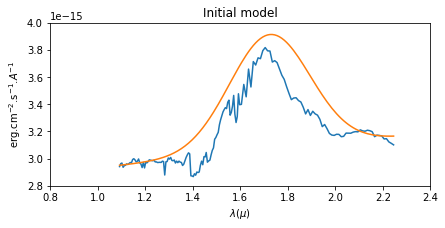

In [4]:
x_label = '$\lambda$($\mu$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [0.8, 2.4, 2.8e-15, 4.e-15]
plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.plot(w2, model(w2))
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("Initial model")

## Try the Sherpa optimizers

### Gaussian $x_{0}$ is fixed.

In [5]:
def try_sherpa(optimizer):
    print("Input      Fitted")
    print("  z         z   mean  sigma amplitude")
    for z in np.linspace(0.0, 2.5, 40):
        rs = RedshiftScaleFactor(z).inverse
        model = rs | (gaussian + linear)        

        model.fixed['mean_1'] = True
        fitter = SherpaFitter(statistic='leastsq', optimizer=optimizer, estmethod='confidence')
        fitted_model = fitter(model, w2, f2)

        fitted_z =  RedshiftScaleFactor(fitted_model.parameters[0]).inverse.z.value
        fitted_height = fitted_model.amplitude_1.value
        fitted_mean = fitted_model.mean_1.value
        fitted_sigma = fitted_model.stddev_1.value
        print("%4.2f     %5.2f %5.2f %5.2f %5.2g" % (z, fitted_z, fitted_mean, fitted_sigma, fitted_height))

### Levemberg-Marquard

In [6]:
try_sherpa('levmar')

Input      Fitted
  z         z   mean  sigma amplitude
0.00     -0.01  1.72  0.12 6.7e-16
0.06     -0.01  1.72  0.12 6.7e-16
0.13     -0.01  1.72  0.12 6.7e-16
0.19      0.26  1.72  0.14 -9.1e-16
0.26      0.26  1.72  0.14 -9.1e-16
0.32      0.26  1.72  0.14 -9.1e-16
0.38      0.26  1.72  0.14 -9.1e-16
0.45      0.26  1.72  0.14 -9.1e-16
0.51      0.26  1.72  0.14 -9.1e-16
0.58      0.81  1.72 -0.01 -4.7e-16
0.64      0.26  1.72  0.14 -9.1e-16
0.71      0.26  1.72  0.14 -9.1e-16
0.77      0.26  1.72  0.14 -9.1e-16
0.83      0.26  1.72  0.14 -9.1e-16
0.90      0.26  1.72  0.14 -9.1e-16
0.96      0.26  1.72  0.14 -9.1e-16
1.03      0.26  1.72  0.14 -9.1e-16
1.09      0.26  1.72  0.14 -9.1e-16
1.15      0.26  1.72  0.14 -9.1e-16
1.22      0.26  1.72  0.14 -9.1e-16
1.28      0.26  1.72  0.14 -9.1e-16
1.35      0.26  1.72  0.14 -9.1e-16
1.41      0.26  1.72  0.14 -9.1e-16
1.47      0.26  1.72  0.14 -9.1e-16
1.54      0.26  1.72  0.14 -9.1e-16
1.60      0.26  1.72  0.14 -9.1e-16
1.67      0

Results are no better than with the default astropy levmar optimizer.

### Moncar

In [7]:
try_sherpa('moncar')

Input      Fitted
  z         z   mean  sigma amplitude
0.00      0.00  1.72 -0.12 6.7e-16
0.06     -0.01  1.72  0.12 6.7e-16
0.13     -0.01  1.72 -0.12 6.7e-16
0.19     -0.01  1.72 -0.12 6.7e-16
0.26     -0.01  1.72  0.12 6.7e-16
0.32      0.26  1.72  0.14 -9.1e-16
0.38     -0.01  1.72 -0.12 6.7e-16
0.45     -0.01  1.72  0.12 6.7e-16
0.51     -0.01  1.72 -0.12 6.7e-16
0.58     -0.01  1.72  0.12 6.7e-16
0.64     -0.01  1.72 -0.12 6.7e-16
0.71     -0.01  1.72  0.12 6.7e-16
0.77      0.26  1.72  0.14 -9.1e-16
0.83     -0.01  1.72 -0.12 6.7e-16
0.90     -0.01  1.72  0.12 6.7e-16
0.96      0.26  1.72  0.14 -9.1e-16
1.03      0.26  1.72 -0.14 -9.1e-16
1.09      0.26  1.72  0.14 -9.1e-16
1.15     -0.01  1.72 -0.12 6.7e-16
1.22      0.26  1.72  0.14 -9.1e-16
1.28     -0.01  1.72  0.12 6.7e-16
1.35     -0.01  1.72  0.12 6.7e-16
1.41      2.32  1.72  0.02 3.9e-14
1.47      0.26  1.72  0.14 -9.1e-16
1.54     -0.01  1.72 -0.12 6.7e-16
1.60      0.26  1.72  0.14 -9.1e-16
1.67      0.95  1.72 -0.04

This is unusable. Took 160 sec. to run (Mac OSX 10.10.5, 2.4 GHz Core i5).

### Simplex

In [8]:
# try_sherpa('simplex')

This is also unusable. Just freezes and reports nothing.

### Nelder-Mead

In [9]:
try_sherpa('neldermead')

Input      Fitted
  z         z   mean  sigma amplitude
0.00     -0.01  1.72  0.12 6.7e-16
0.06     -0.01  1.72  0.12 6.7e-16
0.13     -0.55  1.72  0.20 -5.3e-14
0.19     -0.01  1.72  0.12 6.7e-16
0.26     -0.58  1.72  0.23 -1.4e-13
0.32     -0.54  1.72  0.14 -2.4e-12
0.38     -0.47  1.72  0.05 -1.7e-07
0.45     -0.47  1.72  0.05 -6.5e-06
0.51     -0.31  1.72  0.39 -1.5e-15
0.58     -0.50  1.72  0.73 -1e-15
0.64     -0.31  1.72  0.39 -1.5e-15
0.71     -0.31  1.72  0.39 -1.5e-15
0.77     -0.31  1.72  0.39 -1.5e-15
0.83     -0.31  1.72  0.39 -1.5e-15
0.90     -0.31  1.72  0.39 -1.5e-15
0.96     -0.31  1.72  0.39 -1.5e-15
1.03     -0.72  1.72  0.42 -1e-10
1.09     -0.31  1.72  0.39 -1.5e-15
1.15     -0.01  1.72  0.12 6.7e-16
1.22     -0.31  1.72  0.39 -1.5e-15
1.28     -0.01  1.72  0.12 6.7e-16
1.35     -0.01  1.72  0.12 6.7e-16
1.41     -0.01  1.72  0.12 6.7e-16
1.47     -0.01  1.72  0.12 6.7e-16
1.54      0.96  1.72  0.97 8.3e-14
1.60      0.98  1.72  0.98 8.8e-14
1.67      0.40  1.72  

### Gaussian $x_{0}$ is fixed, $h$ and $\sigma$ are bounded to $>=0.$

Note that we cannot set a minimum bound for $z$. We get an error that sounds like a bug:
```
ParameterErr: parameter wrap_.z_0 has a minimum of 0
```

In [10]:
def try_sherpa_bounded(optimizer):
    print("Input      Fitted")
    print("  z         z   mean  sigma amplitude")
    for z in np.linspace(0.0, 2.5, 40):
        rs = RedshiftScaleFactor(z).inverse
        model = rs | (gaussian + linear)        

        model.amplitude_1.min = 0.
        model.stddev_1.min = 0.
        
        model.fixed['mean_1'] = True
        fitter = SherpaFitter(statistic='leastsq', optimizer=optimizer, estmethod='confidence')
        fitted_model = fitter(model, w2, f2)

        fitted_z =  RedshiftScaleFactor(fitted_model.parameters[0]).inverse.z.value
        fitted_height = fitted_model.amplitude_1.value
        fitted_mean = fitted_model.mean_1.value
        fitted_sigma = fitted_model.stddev_1.value
        print("%4.2f     %5.2f %5.2f %5.2f %5.2g" % (z, fitted_z, fitted_mean, fitted_sigma, fitted_height))

In [11]:
try_sherpa_bounded('levmar')

Input      Fitted
  z         z   mean  sigma amplitude
0.00     -0.01  1.72  0.12 6.7e-16
0.06     -0.01  1.72  0.12 6.7e-16
0.13     -0.01  1.72  0.12 6.7e-16
0.19     -0.01  1.72  0.12 6.7e-16
0.26      0.38  1.72  6.99 2.3e-17
0.32      0.49  1.72  0.24     0
0.38      1.80  1.72  0.13     0
0.45      0.47  1.72  1.15 1.5e-15
0.51      0.50  1.72  0.15     0
0.58      0.81  1.72  0.02  0.17
0.64      0.18  1.72  0.14     0
0.71      0.55  1.72  0.01 0.096
0.77     -0.01  1.72  0.12 6.7e-16
0.83     -0.30  1.72  0.00     0
0.90     -0.25  1.72  0.00     0
0.96      0.02  1.72  0.00     0
1.03      0.87  1.72  0.23     0
1.09      0.14  1.72  0.00     0
1.15      0.60  1.72  0.01 0.095
1.22      1.75  1.72  0.04  0.33
1.28      0.20  1.72  0.00     0
1.35     -0.04  1.72  0.00     0
1.41     -0.02  1.72  0.00     0
1.47      0.18  1.72  0.00     0
1.54     -0.01  1.72  0.12 6.7e-16
1.60      1.21  1.72  0.23     0
1.67      1.30  1.72  0.25     0
1.73      1.50  1.72  0.29     0
1.79

In [12]:
try_sherpa_bounded('moncar')

Input      Fitted
  z         z   mean  sigma amplitude
0.00      0.00  1.72  0.12 6.7e-16
0.06     -0.01  1.72  0.12 6.7e-16
0.13     -0.01  1.72  0.12 6.7e-16
0.19     -0.01  1.72  0.12 6.7e-16
0.26      2.74  1.72  0.03 2.3e-15
0.32     -0.01  1.72  0.12 6.7e-16
0.38     -0.01  1.72  0.12 6.7e-16
0.45     -0.01  1.72  0.12 6.7e-16
0.51     -0.01  1.72  0.12 6.7e-16
0.58     -0.01  1.72  0.12 6.7e-16
0.64     -0.01  1.72  0.12 6.7e-16
0.71     -0.01  1.72  0.12 6.7e-16
0.77     -0.01  1.72  0.12 6.7e-16
0.83     -0.01  1.72  0.12 6.7e-16
0.90     -0.01  1.72  0.12 6.7e-16
0.96      1.50  1.72  0.03 1.5e-21
1.03      3.46  1.72  0.07 2e-15
1.09     -0.01  1.72  0.12 6.7e-16
1.15     -0.01  1.72  0.12 6.7e-16
1.22     -0.01  1.72  0.12 6.7e-16
1.28     -0.01  1.72  0.12 6.7e-16
1.35     -0.01  1.72  0.12 6.7e-16
1.41     -0.01  1.72  0.12 6.7e-16
1.47     -0.01  1.72  0.12 6.7e-16
1.54     -0.01  1.72  0.12 6.7e-16
1.60      0.86  1.72  0.01 1.3e-14
1.67     -0.01  1.72  0.12 6.7e-16
1

In [13]:
# try_sherpa_bounded('simplex')
#
# this freezes at the very start

In [14]:
try_sherpa_bounded('neldermead')

Input      Fitted
  z         z   mean  sigma amplitude
0.00      0.00  1.72  0.17 8.5e-16
0.06      0.06  1.72  0.17 8.5e-16
0.13     -0.39  1.72  0.01 0.0045
0.19     -0.41  1.72  0.02 1.7e-16
0.26     -0.42  1.72  0.01 7.4e-14
0.32     -0.42  1.72  0.00 7.7e-11
0.38     -0.39  1.72  0.01 1.9e-13
0.45     -0.54  1.72  0.13 1e-15
0.51     -0.40  1.72  0.00 6.5e-14
0.58     -0.47  1.72  0.03  0.03
0.64     -0.42  1.72  0.05 4.2e-17
0.71     -0.42  1.72  1.23 2.1e-18
0.77     -0.40  1.72  0.02 2.6e-16
0.83     -0.42  1.72  0.01   0.1
0.90     -0.44  1.72  0.02 0.099
0.96     -0.41  1.72  0.01 0.014
1.03     -0.41  1.72  0.00 1.3e-07
1.09     -0.36  1.72  0.00 1.6e-14
1.15      0.01  1.72  0.07 7.7e-16
1.22     -0.04  1.72  0.07 7.9e-16
1.28     -0.04  1.72  0.08 8.3e-16
1.35     -0.01  1.72  0.13 7.4e-16
1.41      0.01  1.72  0.08 6.1e-16
1.47     -0.04  1.72  0.07 7.2e-16
1.54     -0.24  1.72  1.96 6.2e-15
1.60      1.75  1.72  1.02 1.7e-15
1.67      1.81  1.72  1.02 1.6e-15
1.73      